In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [19]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [20]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X.head()

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,0.333300,1,0,0,3,3,2201,9585,8132,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,68,0.473700,1,0,0,1,2,5554,18174,12989,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,109,0.809500,1,0,0,1,2,6054,38265,3587,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,3256,0.703723,1,0,0,1,3,4004,2617,8755,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,479,0.794100,1,0,0,1,2,3861,4178,11905,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [21]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311610646e-48, 'percent_dependent'),
 (1.4293811306587033e-24, '5_year_declining_balance'),
 (1.3527931483014148e-21, 'federal_loan_rate'),
 (6.095800240149737e-17, 'percent_black'),
 (3.249757484509402e-15, 'fafsa_sent'),
 (2.3099399670297378e-10, '7_yr_repayment_completion'),
 (5.332261659651027e-09, 'first_generation'),
 (1.407934457452266e-08, 'part_time_share'),
 (1.516370320447562e-08, 'dep_low_income'),
 (5.3899600324359155e-08, 'percent_pell_grant'),
 (2.942362811776623e-06, 'students_with_any_loans'),
 (9.035892891499908e-

1.How would you interpret P-values returned by the SelectKBest test above? What was intuitive? What was surprising? Does the P value determine how big (or small) of an effect accreditation has on for-profit status? What might be some guesses as to why this is the case?

#insert 1
The P value I interpreted means that the lower it is, the more the feature is correlated to the y (for profit). I can't really say anything is suprising or intuitive as  I have minimal knowledge of economy, but I find the fact that 7 yrs repayment completion to have such a low correlation to be suprising as I figured that depending on profit the repayment (retirment fees?) should be more likely to be present

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [22]:
#insert 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model0 = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=1000)
model0.fit(X_train, y_train)
acc_test = model0.score(X_test, y_test)
print(f"test_score = {acc_test}")

test_score = 0.8991097922848664


3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [23]:
#insert 3
scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores_ = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    scores.append((k, scores_.mean()))

scores = pd.DataFrame(scores, columns=['k', 'accuracy']).set_index('k')
k_max = scores[scores.accuracy==max(scores.accuracy)]
k_max

,accuracy
k,
7,0.895294


4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [24]:
#insert 4
print(classification_report(y, model0.predict(X)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3835
           1       0.87      0.90      0.89      2905

    accuracy                           0.90      6740
   macro avg       0.90      0.90      0.90      6740
weighted avg       0.90      0.90      0.90      6740



The precision for 0 is how many predicted non-profit universities are actually non-profit, and the precision for 1 is how many predicted for profit universities were actually for profit.

The recall for 0 is how many non-profit universities were predicted out of all the non-profit universities, and the recall for for 1 is how many for profit universities out of all for profit universities were predicted.

The F1 score is the balance between precision and recall for 0 and 1. The accuracy is the overall score of the the predictions, all the correct predictions over total predictions.

5.Print a confusion matrix and describe what it means in your context.

In [25]:
#insert 5
confusion_matrix(y, model0.predict(X))

array([[3439,  396],
       [ 276, 2629]])

3438 out of 3858 predicted non-profit universities are actually non-profit, and 397 out of those 3858 are for profit.
2622 out of the 2905 predicted for profit universities were for profit, and 283 of those 2905 are non-profit.

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

In [42]:
#insert 6
# this is your plotting function
def plot_roc(ytrue, yproba, model, title='ROC plot of naive bayes, logistic, gradient boosting, and KNN'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-0.02, 0.82])
    plt.ylim([0.3, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

In [27]:
y_KNN = model0.predict_proba(X_test)[:, 1]

model1 = naive_bayes.GaussianNB()
model1.fit(X_train, y_train)
y_NB = model1.predict_proba(X_test)[:, 1]

model2 = GradientBoostingClassifier()
model2.fit(X_train, y_train)
y_GB = model2.predict_proba(X_test)[:, 1]

model3 = LogisticRegression()
model3.fit(X_train, y_train)
y_LR = model3.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


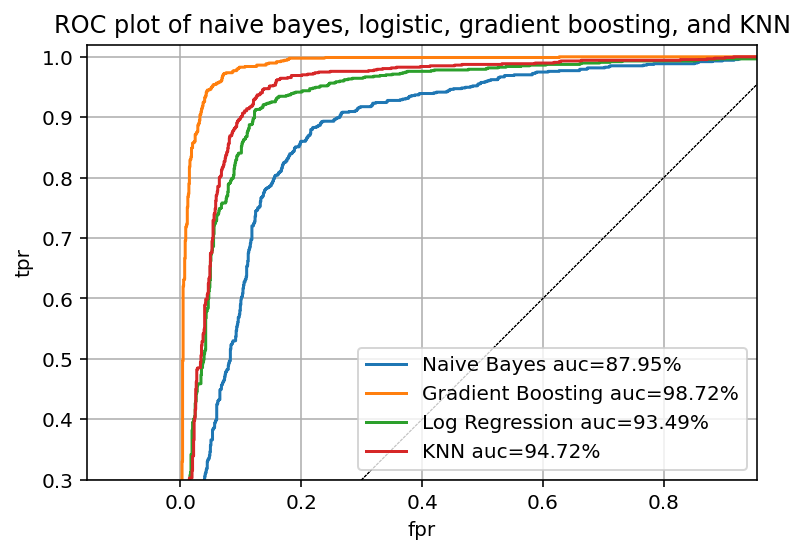

In [43]:
plot_roc(y_test, y_NB, "Naive Bayes")
plot_roc(y_test, y_GB, "Gradient Boosting")
plot_roc(y_test, y_LR, "Log Regression")
plot_roc(y_test, y_KNN, "KNN")

7.Using the logarithmic regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

<ipython-input-29-c5d4698c6b52>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, z, cmap=plt.cm.Paired)


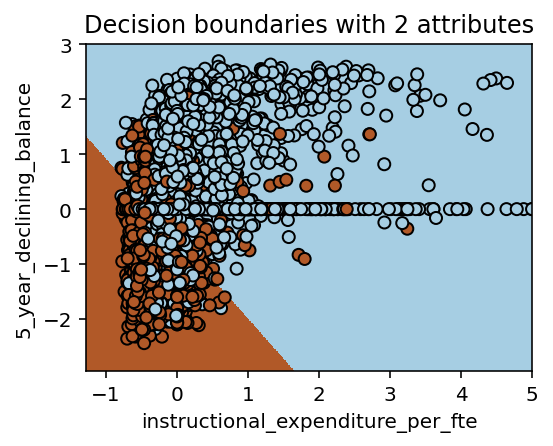

In [29]:
#insert 7
feature1 = 'instructional_expenditure_per_fte'
feature2 = '5_year_declining_balance'
X = X[[feature1, feature2]]  # setting up the features, this much I can unders

model = LogisticRegression(multi_class = 'auto', solver = 'lbfgs', max_iter = 10000)  # creating a model

X_scalar = StandardScaler()
x2 = X_scalar.fit_transform(X)  # applying a standard scalar transformation
x2 = pd.DataFrame(x2)

Q = x2.values
h = 0.01  # smaller mesh size would lead to more resources used
x_min, x_max = Q[:, 0].min() - 0.5, Q[:, 0].max() + 0.5
y_min, y_max = Q[:, 1].min() - 0.5, Q[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # h is like a step size, so it owuld make sense to be bigger if we want it faster

# from here on down is mostly plotting, and I don't really understand
model.fit(x2, y)
z = model.predict(np.c_[xx.ravel(), yy.ravel()])

z = z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, z, cmap=plt.cm.Paired)

plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
plt.title("Decision boundaries with 2 attributes")
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.xlim(xx.min(), 5)
plt.ylim(yy.min(), 3)
plt.show()

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

In [35]:
#insert 8
model4 = RandomForestClassifier()
model4.fit(X_train, y_train)
y_RF = model4.predict_proba(X_test)[:, 1]

9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [36]:
#insert 9
model5 = SVC(probability=True)
model5.fit(X_train, y_train)
y_SV = model5.predict_proba(X_test)[:, 1]

10. Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, KNN classifiers, random forest, and SVM classifiers.

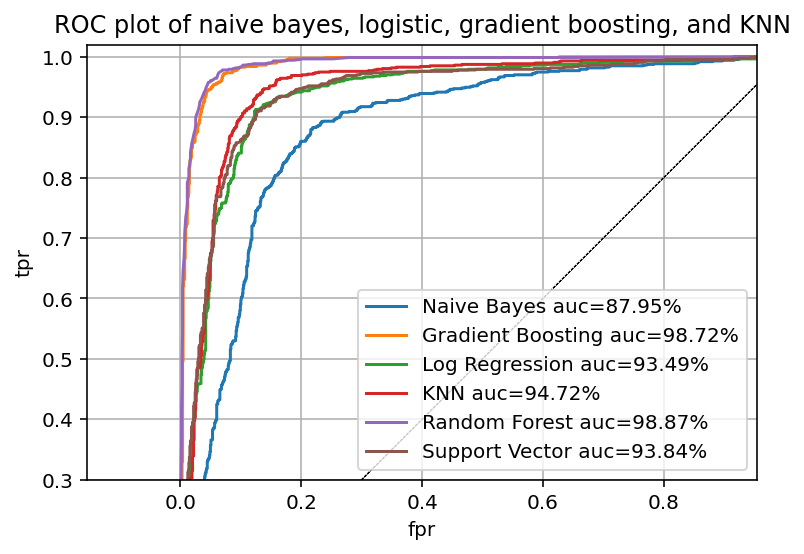

In [48]:
#insert 10
plot_roc(y_test, y_NB, "Naive Bayes")
plot_roc(y_test, y_GB, "Gradient Boosting")
plot_roc(y_test, y_LR, "Log Regression")
plot_roc(y_test, y_KNN, "KNN")
plot_roc(y_test, y_RF, "Random Forest")
plot_roc(y_test, y_SV, "Support Vector")

11.Take in a new school's data and predict the school's profit status using one of your previous classifier methods.

In [47]:
X_test.columns

Index(['size', 'retention', 'branches', 'online_only', 'under_investigation',
       'most_common_degree', 'highest_degree', 'faculty_salary',
       'instructional_expenditure_per_fte', 'tuition_revenue_per_fte',
       'part_time_share', 'age_entry', 'percent_dependent', 'first_generation',
       'percent_black', 'avg_family_income', 'ind_low_income',
       'dep_low_income', 'loan_principal', 'federal_loan_rate',
       'students_with_any_loans', 'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n'],
      dtype='object')

In [102]:
#insert 11
# using random Forest
new = df.sample(n=1)
name = new[['name']]
new = new[['size', 'retention', 'branches', 'online_only', 'under_investigation',
       'most_common_degree', 'highest_degree', 'faculty_salary',
       'instructional_expenditure_per_fte', 'tuition_revenue_per_fte',
       'part_time_share', 'age_entry', 'percent_dependent', 'first_generation',
       'percent_black', 'avg_family_income', 'ind_low_income',
       'dep_low_income', 'loan_principal', 'federal_loan_rate',
       'students_with_any_loans', 'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n']]
d = new.values.tolist()
a = model4.predict(d)
print(name)
print('the prediction for the college is: ', a)

                                               name
3597  Minnesota State College-SE Technical-Red Wing
the prediction for the college is:  [0]


12.What are the worst schools? Some of them are chains of schools so don't necessarily consider singular names but generalize to chains. Give a lot of justification for your analysis as everyone might have a different answer here. Insert these responses into your blog.

In [124]:
# insert 12
df_worst = df[df.for_profit == 1]  # only looking at the ones which are for profit

# worst school based on federal loan
fed = df.loc[[df_worst['federal_loan_rate'].argmax()]]['name'][df_worst['federal_loan_rate'].argmax()]
print('worst in terms of federal loan: ', fed)

# worst school based on lowest dependent income
dep = df.loc[[df_worst['dep_low_income'].argmin()]]['name'][df_worst['dep_low_income'].argmin()]
print('worst in terms of lowest dependent income: ', dep)

# worst school based on price to space
ft = df.loc[[df_worst['tuition_revenue_per_fte'].argmin()]]['name'][df_worst['tuition_revenue_per_fte'].argmin()]
print('worst in terms of: ', ft)

worst in terms of federal loan:  University Academy of Hair Design
worst in terms of lowest dependent income:  Professional Hands Institute
worst in terms of:  Chaffey College


13.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory? Give a lot of detail here as well in your blog.

#insert 13
Likely federal loan rate and whether or not the schools are acreditted, because that is what the government needs to know, the taxes paid are spent wisely, aside from that, perhaps also income level and whether or not they are dependent. If the government is to be more strict, perhaps they should look into any loan too.

14.Read several articles on college predatory practices and cite and incorporate them into your blog discussion. Remember to link to them clearly by using the 
```[here](http://....)``` syntax.